# Studying the correlation between drug-induced transcriptomic response and known targets

Data used (generated in the previous notebook):
- target_vectors.tsv (vectors representing the known targets of each drug)
- transcriptional_response_vectors.tsv (vectors representing the DEG induced by each drug)

In both matrices, the rows are chemicals and the columns are genes. The order of rows/columns is the same in both.

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import linregress
from scipy.stats import pearsonr

import getpass
import sys
import time
from tqdm import tqdm, tqdm_notebook
import string
import warnings
warnings.filterwarnings('ignore')

from utils import (get_pearson_corr, 
                     get_cosine_correlation, 
                     get_jaccard_correlation,
                     get_pearson_corr_permutation, 
                     get_cosine_corr_permutation, 
                     get_jaccard_corr_permutation,
                     get_similarity,
                     get_similarity_permutation,
                     get_nonzero_similarity,
                     get_nonzero_similarity_permutation)

In [16]:
getpass.getuser()

'chloehart'

In [17]:
sys.version

'3.8.11 (default, Aug  6 2021, 08:56:27) \n[Clang 10.0.0 ]'

In [18]:
time.asctime()

'Tue Nov  1 09:35:48 2022'

In [39]:
databases = ['ChemPert', 'ChemPert(KEGG)', 'KEGG_15_200', 'KEGG_100_300', 'KEGG_top_100', 
             'KEGG_top_50', 'KEGG_top_250']

## Load drug-induced transcriptomic response 

In [40]:
#Get transcript data frame for each database
transcript_df = {}
for database in tqdm(databases):
    transcriptomic_responses_df = pd.read_csv(
    '../data/Transcriptional_data_frames/transcriptional_response_vectors.tsv',
    sep='\t',
    index_col=0,
    )
    transcriptomic_responses_df.head(4)
    transcriptomic_responses_df.shape
    transcript_df[database] = transcriptomic_responses_df.copy()

100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.35s/it]


## Load the known targets for each drug

In [41]:
#Get target data frame for each database
target_df = {}
for database in tqdm(databases):
    if database == 'ChemPert':
        targets_df = pd.read_csv(
            '../data/target_data_frames/target_vectors_' + database + '.tsv',
            sep='\t',
            index_col=0,
        )
    else:
        targets_df = pd.read_csv(
            '../test_data/target_data_frames/target_vectors_' + database + '.csv',
            sep=',',
            index_col=0,
        )
        targets_df = targets_df.drop(list(set(targets_df.columns) \
                                      - set(transcript_df[database].columns)), axis=1)
        targets_df.to_csv('../data/target_data_frames/target_vectors_' + database + '.csv')
    target_df[database] = targets_df.copy()

100%|█████████████████████████████████████████████| 7/7 [00:18<00:00,  2.63s/it]


In [42]:
for database in tqdm(databases):
    assert list(target_df[database].columns) == list(transcript_df[database].columns)
    assert list(target_df[database].index) == list(transcript_df[database].index)
    

100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 302.10it/s]


# Get number of nonzero values in the target data frames

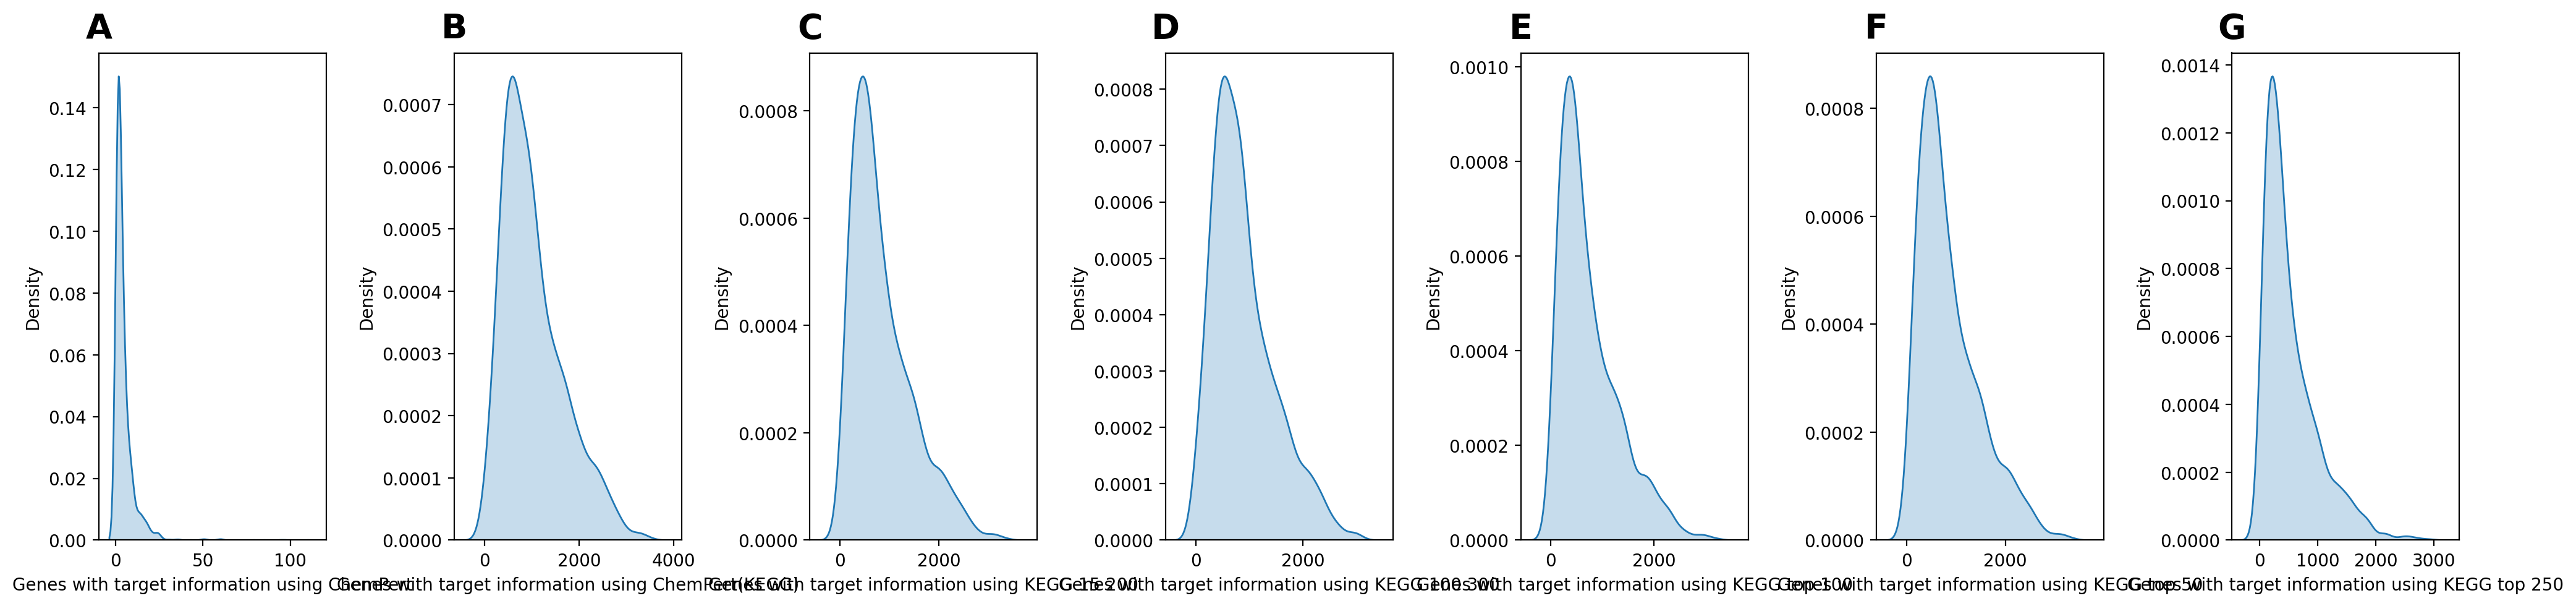

In [43]:
plt.figure(dpi=200, figsize = (20,5))
for i,database in enumerate(databases):
    #Set initial variables
    num_targets = []

    
    #Get number of nonzero targets
    for drug in target_df[database].index.values:
        num_targets.append(len(np.nonzero(list(target_df[database].loc[drug]))[0]))

    #Create plot
    plt.subplot(1, len(databases), i+1)
    sns.kdeplot(num_targets, shade=True)
    plt.xlabel('Genes with target information using ' + database.replace('_', ' '))
    plt.text(0, 1.05, string.ascii_uppercase[i],  
        size=20, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)
    
plt.tight_layout()
plt.savefig('../figures/Supplementary_figure_3.png', bbox_inches='tight')
plt.show()
        

# Calculate Correlation Metrics for each drug

In [44]:
from numpy import dot
from numpy.linalg import norm
from scipy.spatial.distance import jaccard
from matplotlib.lines import Line2D

<Figure size 1920x1440 with 0 Axes>

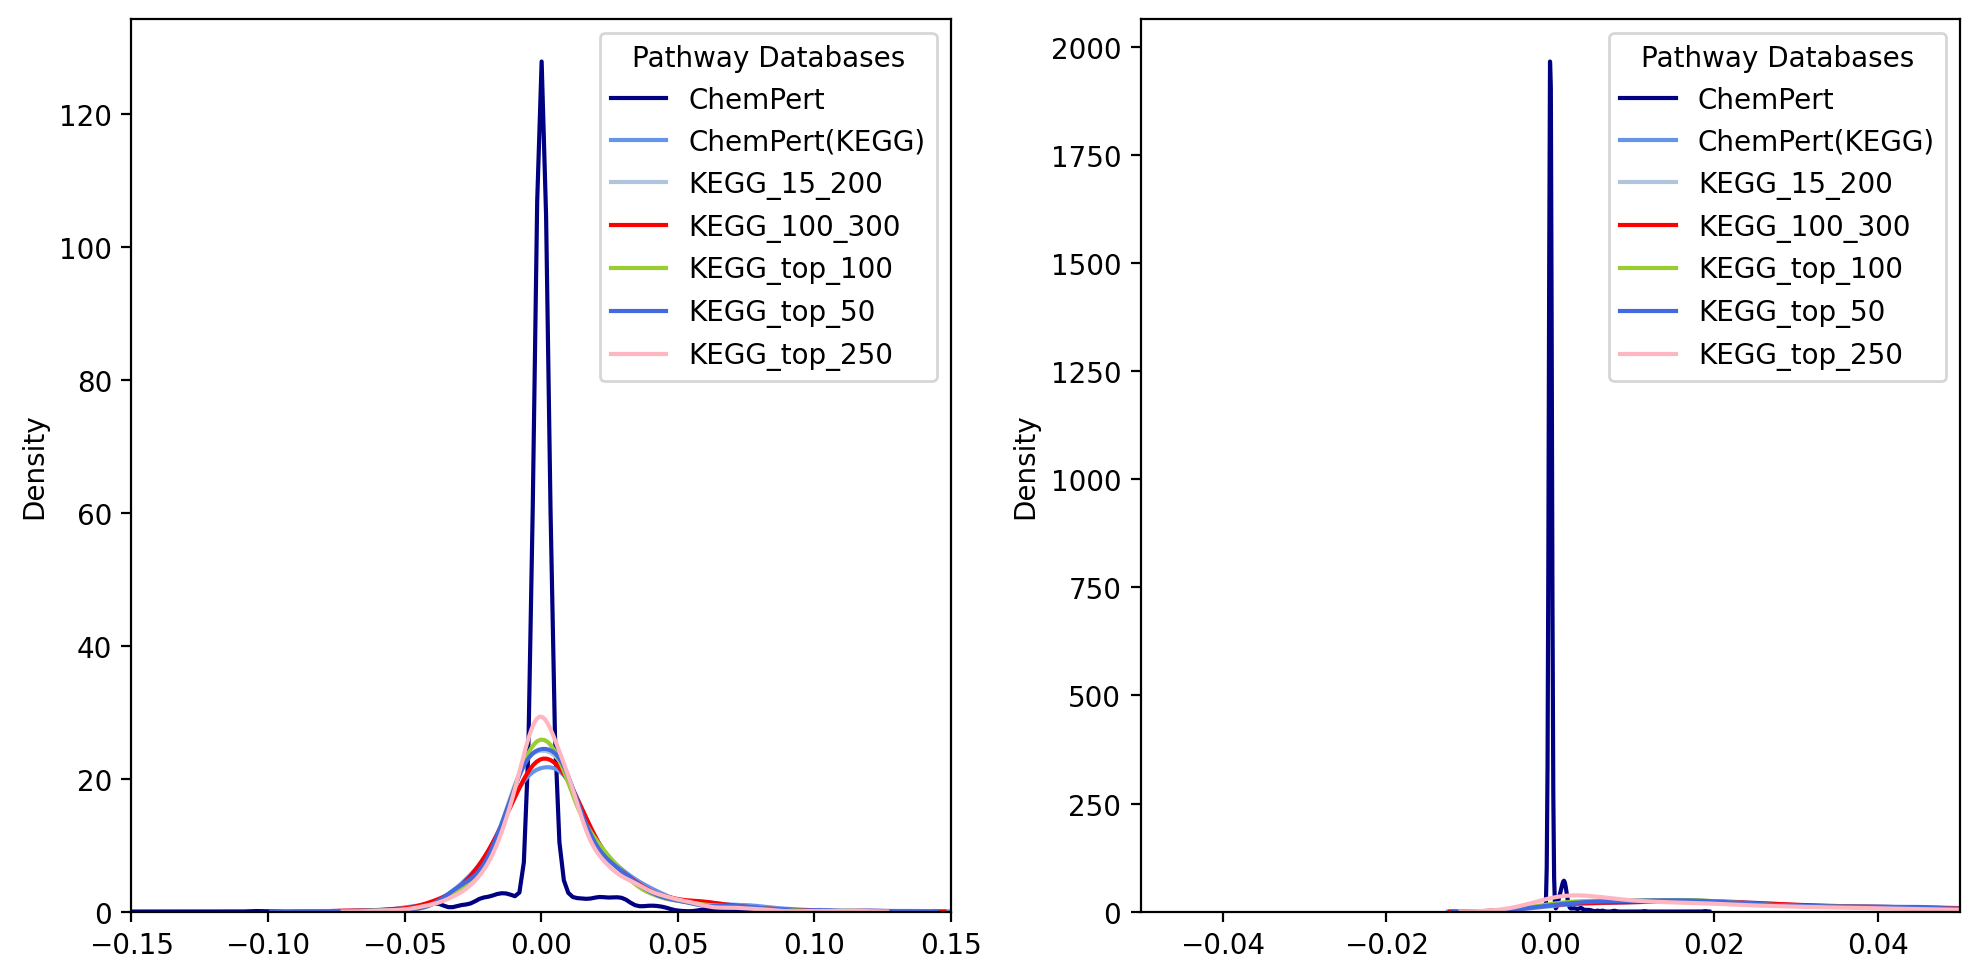

In [45]:
#Set initial variables
pearson_corr_df = {}
colors = ['navy', 'cornflowerblue', 'lightsteelblue','red', 'yellowgreen', 'royalblue', 'lightpink','gold', 'black']
cosine_corr_df = {}
jaccard_corr_df = {}
plt.figure(dpi=300)

#Graph pearson correlation values for each database
plt.figure(figsize=(10,5), dpi =200)
for i,database in enumerate(databases):
    #Get pearson correlation values
    pearson_corr_df[database] = get_pearson_corr(target_matrix=target_df[database], \
                                                transcriptomic_matrix=transcript_df[database])
    
    #Plot Pearson correlation values
    plt.subplot(1,2,1)
    sns.distplot(pearson_corr_df[database].values, color=colors[i], label=database, hist=False)
    plt.xlim([-.15, .15])
    plt.legend(title="Pathway Databases")

    #Get Jaccard Similarity values
    jaccard_corr_df[database] = get_jaccard_correlation(
        target_matrix=target_df[database], 
        transcriptomic_matrix=transcript_df[database]
    )
    
    #Plot Jaccard Similarity values
    plt.subplot(1,2,2)
    sns.distplot(np.array(jaccard_corr_df[database].values), color=colors[i], label=database, hist=False)
    plt.xlim([-.15, .15])
    plt.legend(title="Pathway Databases")
    plt.xlim([-.05,.05])

#Show plot
plt.tight_layout()
plt.savefig('../figures/Supplementary_figure_3.png', bbox_inches='tight')
plt.show()


# Get Pearson Correlation for Drugs with more than 10 targets

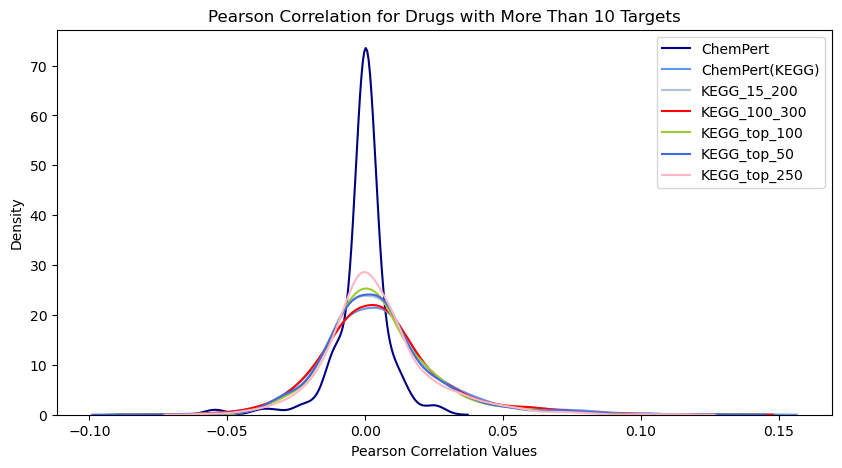

,KS test P-value,Mean Pearson Correlation for Drugs with at least 10 Targets,Mean Pearson Correlation for All Drugs
ChemPert,0.000006,-0.001109,0.000399
ChemPert(KEGG),1.000000,0.005995,0.005963
KEGG_15_200,1.000000,0.004860,0.004832
KEGG_100_300,0.999906,0.005359,0.005239
KEGG_top_100,1.000000,0.004875,0.004834
KEGG_top_50,1.000000,0.004858,0.004831
KEGG_top_250,1.000000,0.004475,0.004429


In [46]:
# Check out the drugs with more than 10 targets and see if they have a higher corrrelation than the rest
plt.figure(figsize=(10,5))
stat_df = pd.DataFrame(columns=['KS test P-value', 'Mean Pearson Correlation for Drugs with at least 10 Targets',\
                             'Mean Pearson Correlation for All Drugs'])
for i,database in enumerate(databases):
    #Set initial variables
    corr_many_targets = []

    #Get drugs with more than 10 targets
    for drug in target_df[database].index.values:
        if np.count_nonzero(target_df[database].loc[drug]) > 10:
            corr_many_targets.append(pearson_corr_df[database].loc[drug, 'pearson_correlation'])


    #Plot the pearson correlation values for drugs with more than 10 targets
    sns.distplot(corr_many_targets, color=colors[i], label=database, hist=False)

    #Print P-value determining whether all drugs and drugs with more than 10 targets
    #come from the same distribution
    stat_1 = stats.ks_2samp(corr_many_targets, np.squeeze(pearson_corr_df[database].values))[1]
    stat_2 = np.nansum(corr_many_targets)/len(corr_many_targets)
    stat_3 = np.nansum(np.squeeze(pearson_corr_df[database].values))/len(np.squeeze(pearson_corr_df[database].values))
    stat_df.loc[database] = [stat_1, stat_2, stat_3]
    
plt.title("Pearson Correlation for Drugs with More Than 10 Targets")
plt.xlabel('Pearson Correlation Values')
plt.legend()
plt.show()
stat_df.head(len(databases))

# Get Pearson Correlation for 50 drugs with the most DEGs

100%|███████████████████████████████████████| 1000/1000 [01:15<00:00, 13.21it/s]


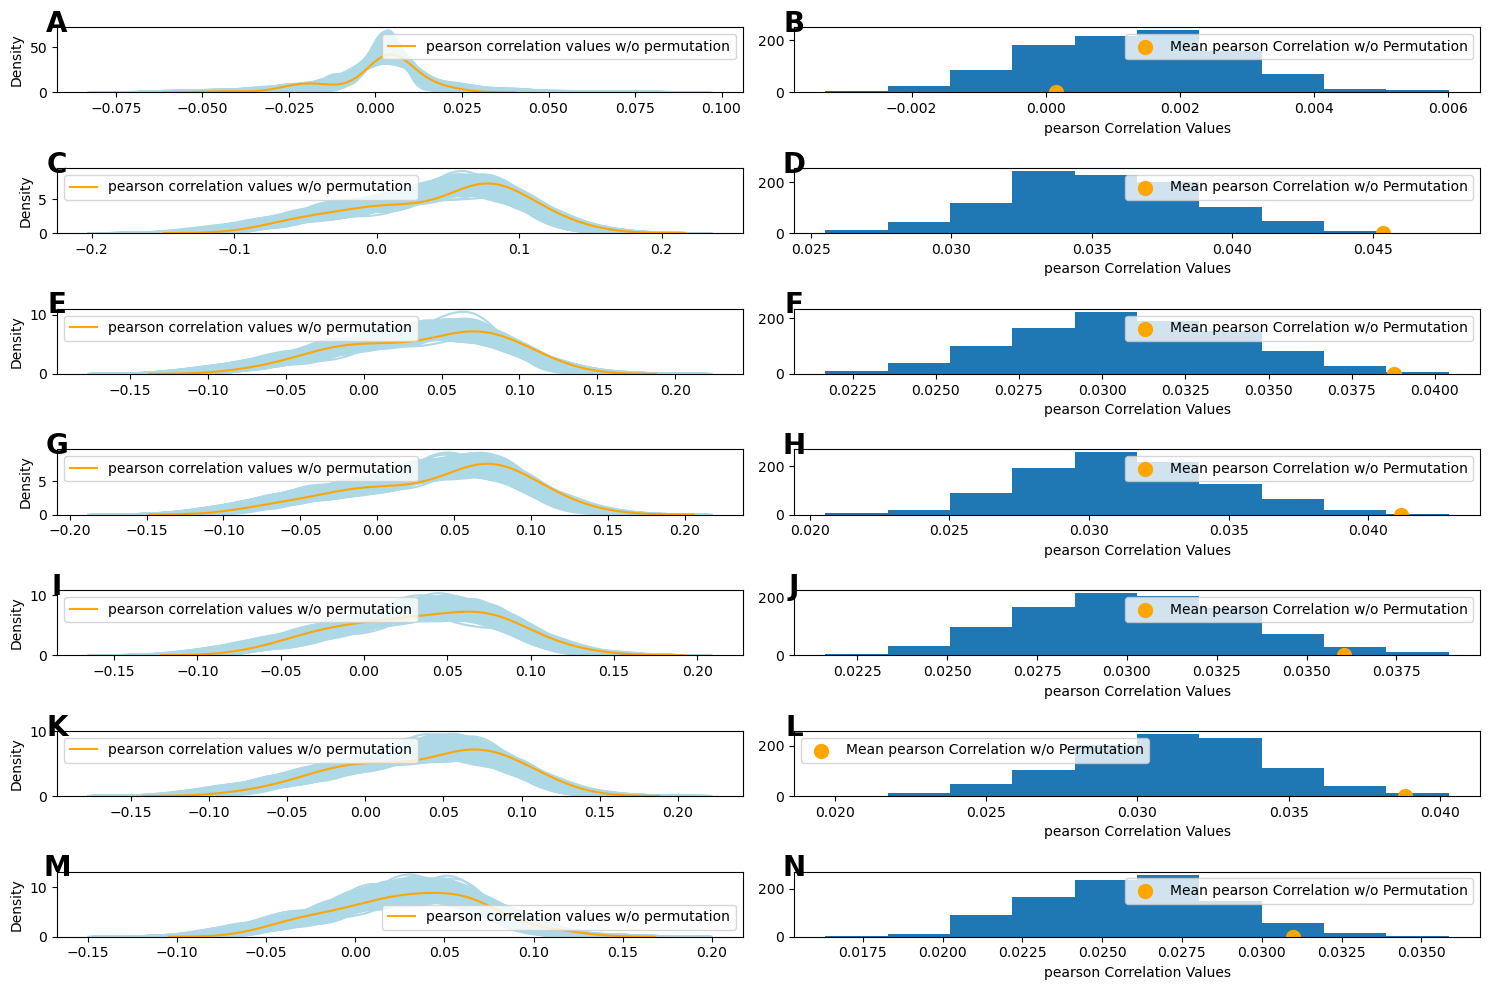

In [47]:
# Check out the top 50 drugs with more DEG (Differentially expressed genes) and see 
#if they have a higher correlation than the rest
stat_df = pd.DataFrame(columns=['KS test P-value', 'Mean pearson Correlation for 50 Drugs with most DEGs',\
                             'Mean pearson Correlation for All Drugs'])
#Set initial variables
current_DEG_corr_df = {}
DEG_corr_df = {}
plt.figure().set_size_inches(15,10)
p_values = []
DEG_drug_trancriptomics = {}
DEG_drug_targets = {}

for j,database in enumerate(databases):
    #Set initial variables
    num_nonzero_vals = {}
    permutation_means = []
    num_compounds = 50
    num_permutations = 1000

    #Get number of DEGs for each drug
    for drug in transcript_df[database].index.values:
        num_nonzero_vals[drug] = np.count_nonzero(transcript_df[database].loc[drug])

    #Get 50 drugs with the most DEGs
    DEG_drugs = [x for _,x in sorted(zip(num_nonzero_vals.values(), num_nonzero_vals.keys()), reverse=True)]
    DEG_corr_df[database] = pearson_corr_df[database].filter(items = DEG_drugs[:50], axis=0)
    corr_DEG_drugs = [pearson_corr_df[database].loc[drug, 'pearson_correlation'] for drug in DEG_drugs[:50]]
    
    DEG_drug_targets[database] = target_df[database].filter(items = DEG_drugs[:50], axis=0)
    DEG_drug_trancriptomics[database] = transcript_df[database].filter(items = DEG_drugs[:50], axis=0)
    
    #calculate pearson correlation for 100 different permutations
    plt.subplot(len(databases), 2, 2*j+1)
    for i in tqdm(range(num_permutations)):
        current_target_df = DEG_drug_targets[database].copy()
        current_transcriptomic_df = DEG_drug_trancriptomics[database].copy()
        current_transcriptomic_df = current_transcriptomic_df.sample(frac=1)
        current_DEG_corr_df[database] = get_pearson_corr_permutation(target_matrix=current_target_df, \
                                                   transcriptomic_matrix=current_transcriptomic_df)
        permutation_means.append(np.nansum(current_DEG_corr_df[database]['pearson_correlation'])/num_compounds)
        sns.distplot(current_DEG_corr_df[database].values, hist=False, color='lightblue')
        
    #Plot pearson correlation scores for the permutations
    sns.distplot(DEG_corr_df[database].values, hist=False, color='orange', label = "pearson correlation values w/o permutation")
    plt.legend()
    plt.text(0, 1.05, string.ascii_uppercase[2*j],  
        size=20, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)
        
    
    #Plot the mean pearson correlation scores for the permutations
    plt.subplot(len(databases), 2, 2*j+2)
    original_mean = np.nansum(DEG_corr_df[database]['pearson_correlation'])/num_compounds
    plt.hist(permutation_means, zorder=0)
    plt.scatter(original_mean, .2, s = 100, \
                label = 'Mean pearson Correlation w/o Permutation', color = 'orange')
    plt.xlabel('pearson Correlation Values')
    plt.legend()
    plt.text(0, 1.05, string.ascii_uppercase[2*j+1],  
        size=20, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)
    plt.tight_layout()

    #Get the permutation test p-value (based on the means)
    p_value = (len([x for x in permutation_means if x >= original_mean])+1)/num_permutations
    p_values.append(p_value)

plt.tight_layout()
plt.show()


In [48]:
#Set initial variables
ks_values = []
stat_df = pd.DataFrame(columns = ['Permutation Test P-value', 'KS Test P-value'])

#Pick random permutation test and do the KS test with the original pearson correlation scores
for i,database in enumerate(databases):
    ks_values.append(stats.ks_2samp(np.squeeze(current_DEG_corr_df[database].values), 
                                                   np.squeeze(DEG_corr_df[database].values))[1])
    stat_df.loc[database] = [p_values[i], ks_values[i]]
    
stat_df.head(len(database))

,Permutation Test P-value,KS Test P-value
ChemPert,0.768,0.966746
ChemPert(KEGG),0.003,0.716647
KEGG_15_200,0.006,0.869262
KEGG_100_300,0.004,0.271914
KEGG_top_100,0.029,0.869262
KEGG_top_50,0.005,0.716647
KEGG_top_250,0.038,0.997711


# Permutate original targets and original perturbations and re-calculate correlations

In [49]:
# Permutate and apply function (x100 times)

### Permutate pairs and apply pearson correlation

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

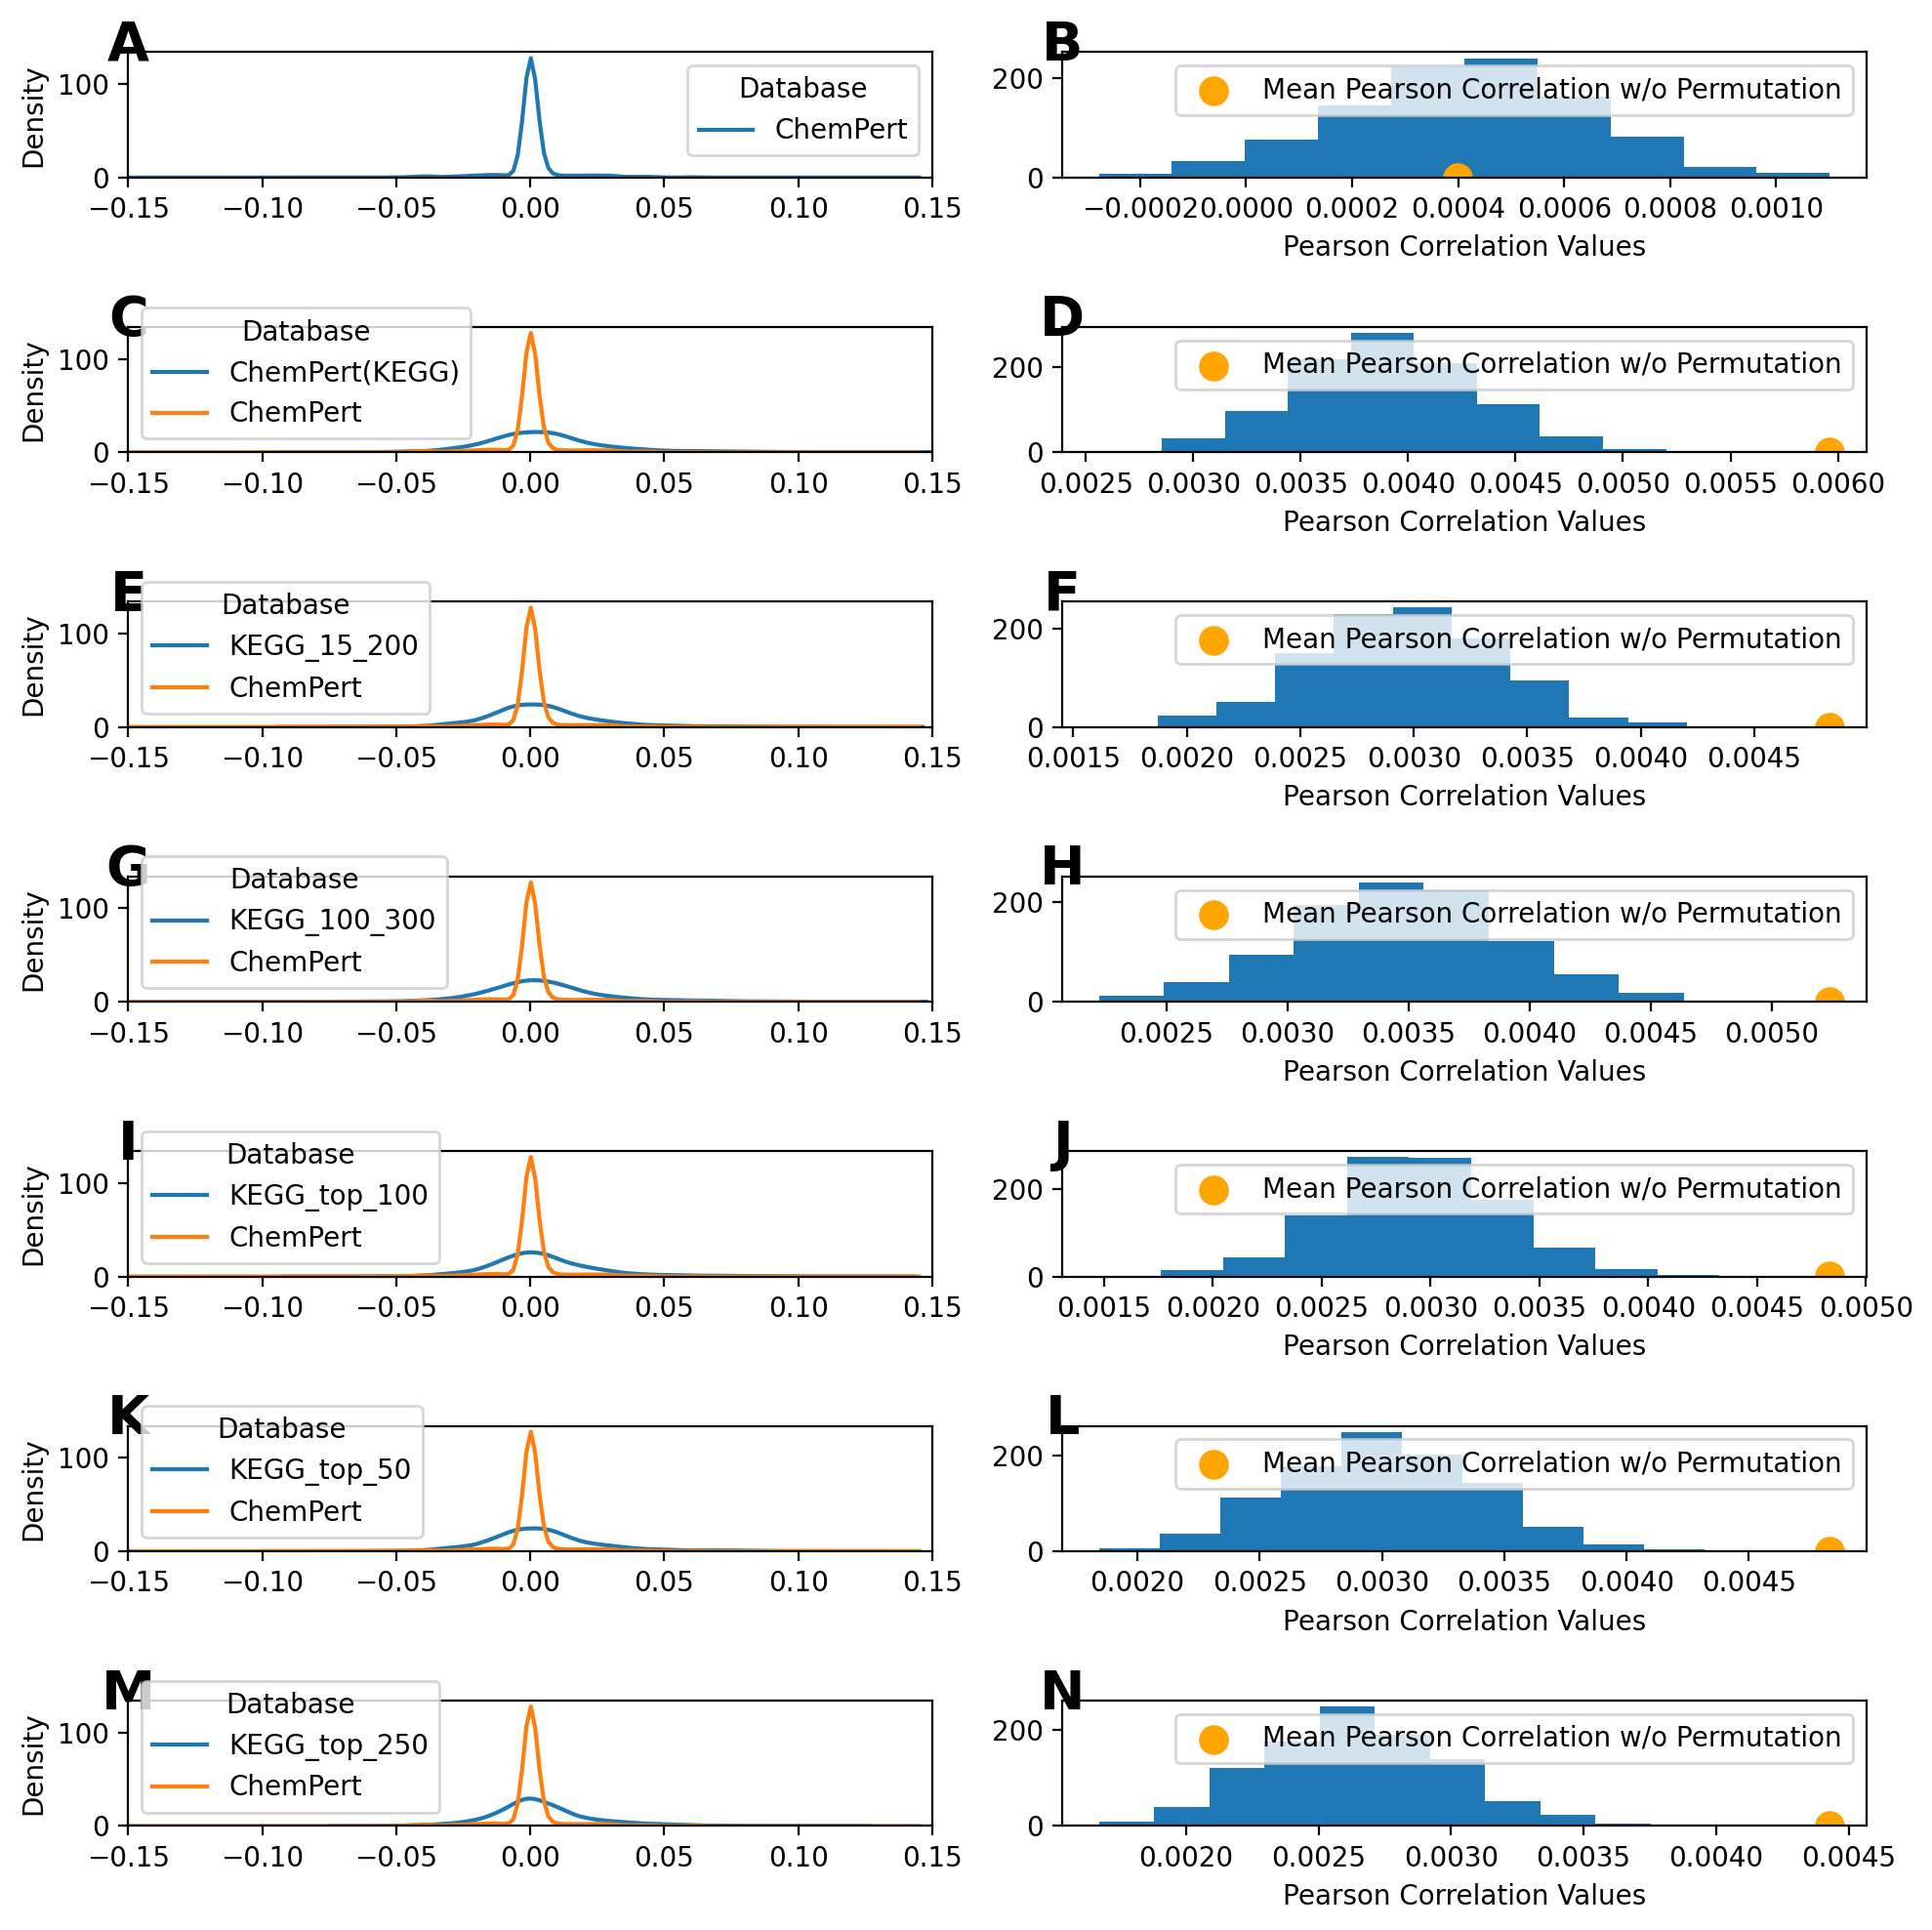

In [50]:
#Set initial variables
current_pearson_corr_df = {}
current_jaccard_corr_df = {}
p_values = []
plt.figure(dpi=200, figsize=([10,10]))

for j,database in enumerate(databases):
    #Set initial variables
    permutation_means = []
    num_compounds = target_df[database].shape[0]
    num_permutations = 1000
  
    #calculate pearson correlation for 100 different permutations
    plt.subplot(len(databases), 2, 2*j+1)
    permutations = [target_df[database].copy().reset_index(drop=True).corrwith(transcript_df[database].copy().sample(frac=1).reset_index(drop=True), 
                                              method='pearson', axis =1).values
                     for i in tqdm_notebook(range(num_permutations))]
    permutation_means = [np.sum(p)/num_compounds for p in permutations]

    #Plot pearson correlation scores for the permutations
    sns.distplot(pearson_corr_df[database].values, hist=False, label=database)
    if database != 'ChemPert':
        sns.distplot(pearson_corr_df['ChemPert'].values, hist=False, label='ChemPert')
    plt.xlim([-.15, .15])
    plt.legend(title='Database')
    plt.text(0, 1.05, string.ascii_uppercase[2*j],  
        size=20, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)

    #Plot the mean pearson correlation scores for the permutations
    plt.subplot(len(databases), 2, 2*j+2)
    original_mean = np.nansum(pearson_corr_df[database]['pearson_correlation'])/num_compounds
    plt.hist(permutation_means, zorder=0)
    plt.scatter(original_mean, .2, s = 100, \
                label = 'Mean Pearson Correlation w/o Permutation', color = 'orange')
    plt.xlabel('Pearson Correlation Values')
    plt.legend()
    plt.text(0, 1.05, string.ascii_uppercase[2*j+1],  
        size=20, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)
    

    #Get the permutation test p-value (based on the means)
    p_value = (len([x for x in permutation_means if x >= original_mean])+1)/num_permutations
    p_values.append(p_value)
    
plt.tight_layout()
plt.savefig('../figures/figure_3.png')
plt.show()

In [51]:
#Set initial variables
ks_values = []
stat_df = pd.DataFrame(columns = ['Permutation Test P-value'])

#Pick random permutation test and do the KS test with the original pearson correlation scores
for i,database in enumerate(databases):
#         ks_values.append(stats.ks_2samp(np.squeeze(current_pearson_corr_df[database].values), 
#                                                        np.squeeze(pearson_corr_df[database].values))[1])
    stat_df.loc[database] = p_values[i]
    
stat_df.head(len(database))

,Permutation Test P-value
ChemPert,0.537
ChemPert(KEGG),0.001
KEGG_15_200,0.001
KEGG_100_300,0.001
KEGG_top_100,0.001
KEGG_top_50,0.001
KEGG_top_250,0.001


### Permutate pairs and apply Jaccard similarity

In [52]:
from scipy.spatial.distance import jaccard
def jaccard_corr(x,y):
    return 1 - jaccard(x,y)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

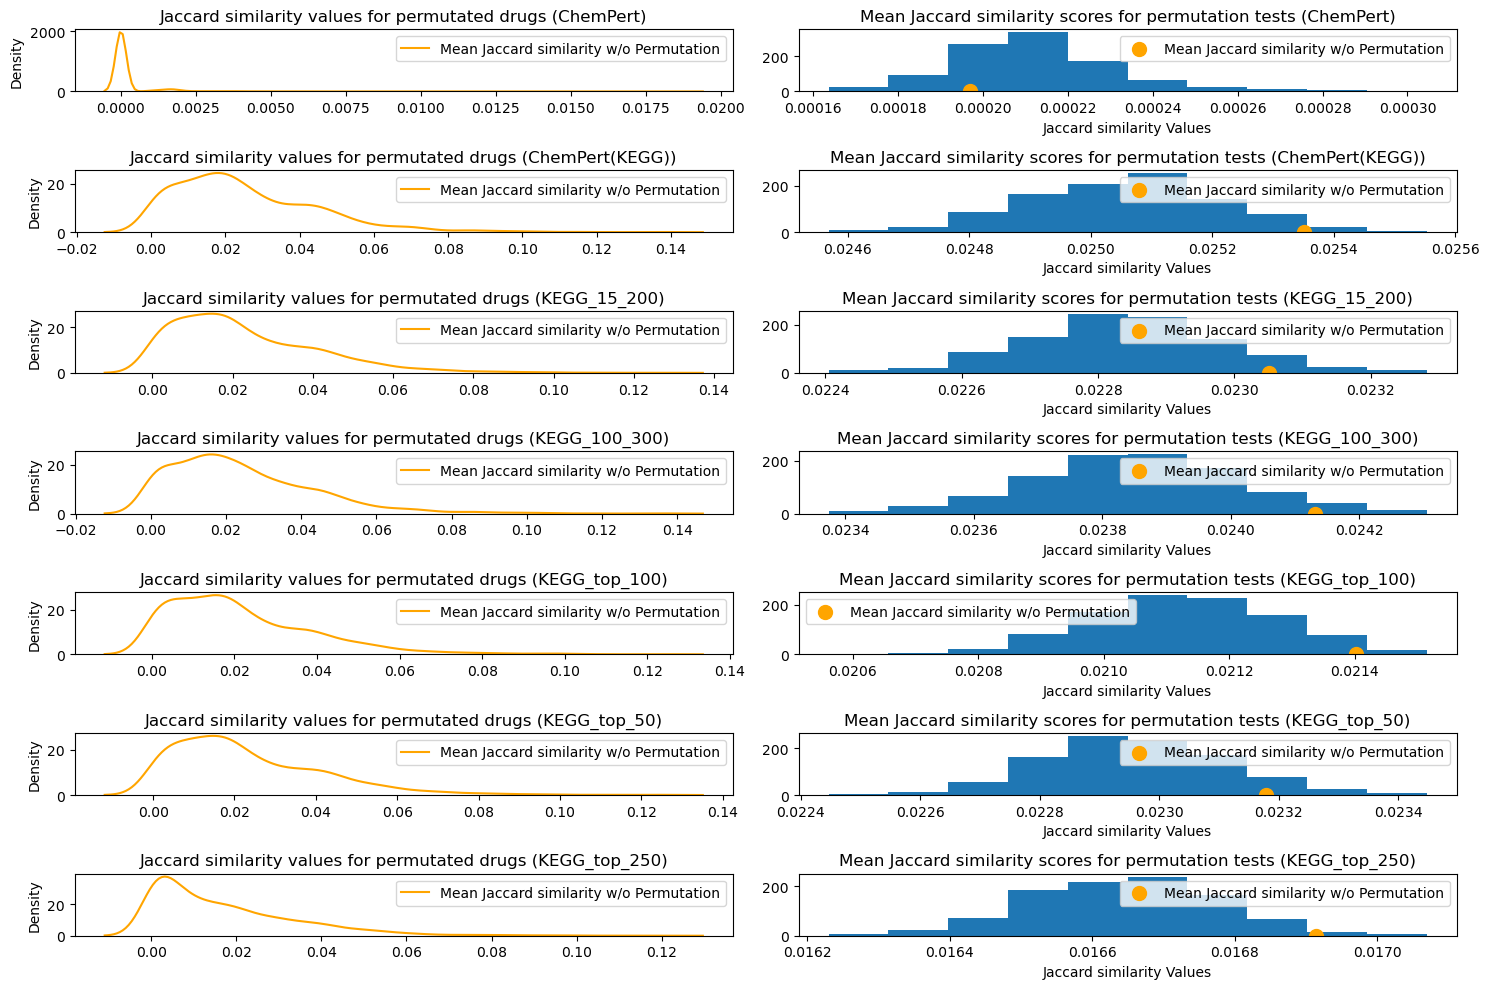

In [53]:
current_jaccard_corr_df = {}
plt.figure().set_size_inches(15,10)
p_values = []

for j,database in enumerate(databases):
    #Set initial variables
    permutation_means = []
    num_compounds = target_df[database].shape[0]
    num_permutations = 1000

    #Get Jaccard similarity scores for 100 different permutations
    plt.subplot(len(databases), 2, 2*j+1)
    permutation_means = [np.sum(target_df[database].copy().reset_index(drop=True).corrwith(transcript_df[database].copy().sample(frac=1).reset_index(drop=True), 
                                                  method=jaccard_corr, axis =1))/num_compounds 
                     for i in tqdm_notebook(range(num_permutations))]

    #Plot Jaccard similarity scores for the permutations
    sns.distplot(jaccard_corr_df[database].values, hist=False, color='orange', label = 'Mean Jaccard similarity w/o Permutation')
    plt.legend()
    plt.title("Jaccard similarity values for permutated drugs (" + database + ")")
    plt.legend()

    #Plot the mean Jaccard similarity scores for the permutations
    original_mean = sum(jaccard_corr_df[database]['jaccard_correlation'])/num_compounds
    plt.subplot(len(databases), 2, 2*j+2)
    plt.hist(permutation_means, zorder=0)
    plt.scatter(original_mean,.2, s=100,\
                label = 'Mean Jaccard similarity w/o Permutation', color = 'orange')
    plt.xlabel('Jaccard similarity Values')
    plt.title("Mean Jaccard similarity scores for permutation tests (" + database + ")")
    plt.legend()

    #Get the p-value for the permutation test (based on the means)
    p_value = (len([x for x in permutation_means if x >= original_mean])+1)/num_permutations
    p_values.append(p_value)
    
plt.tight_layout()
plt.show()

In [54]:
#Set initial variables
ks_values = []
stat_df = pd.DataFrame(columns = ['Permutation Test P-value'])

#Pick random permutation test and do the KS test with the original jaccard similarity scores
for i,database in enumerate(databases):
    stat_df.loc[database] = [p_values[i]]
    
stat_df.head(len(databases))

,Permutation Test P-value
ChemPert,0.801
ChemPert(KEGG),0.029
KEGG_15_200,0.080
KEGG_100_300,0.048
KEGG_top_100,0.033
KEGG_top_50,0.075
KEGG_top_250,0.020
